In [1]:
!pip install rdkit-pypi rdkit torch transformers pytorch-lightning requests

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 65.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.2/35.2 MB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 58.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing ins

In [2]:
import os
import sys
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from transformers import AutoTokenizer, AutoModel
from rdkit import Chem, RDLogger, DataStructs
from rdkit.Chem import AllChem
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr, spearmanr
import pandas as pd
import numpy as np
import logging
import psutil
import random
from typing import Dict, Optional, List, Any

# Suppress RDKit warnings
RDLogger.DisableLog('rdApp.*')

# Setup logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[logging.StreamHandler(sys.stdout)],
    force=True
)
logger = logging.getLogger(__name__)
logger.info("Logging initialized")

# Reproducibility
def seed_everything(seed: int = 42) -> None:
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
seed_everything()

# Memory logging
def log_memory_usage() -> None:
    process = psutil.Process()
    mem_info = process.memory_info()
    logger.info(f"Memory usage: {mem_info.rss / 1024**2:.2f} MB")

# SMILES canonicalization
def canonicalize_smiles(smiles: str) -> Optional[str]:
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        return Chem.MolToSmiles(mol, canonical=True)
    except Exception as e:
        logger.error(f"SMILES canonicalization failed: {e}")
        return None

# Fuzzy SMILES matching
def fuzzy_smiles_match(smiles1: str, smiles2: str, threshold: float = 0.7) -> bool:
    try:
        mol1 = Chem.MolFromSmiles(smiles1)
        mol2 = Chem.MolFromSmiles(smiles2)
        if mol1 is None or mol2 is None:
            return False
        fp1 = AllChem.GetMorganFingerprintAsBitVect(mol1, 2, 2048)
        fp2 = AllChem.GetMorganFingerprintAsBitVect(mol2, 2, 2048)
        return DataStructs.TanimotoSimilarity(fp1, fp2) >= threshold
    except:
        return False

# Load BindingDB
def load_bindingdb(path: str, max_samples: int = 20000, chunksize: int = 100000) -> Optional[pd.DataFrame]:
    logger.info(f"Loading BindingDB from {path}")
    try:
        required_cols = ["Ligand SMILES", "Kd (nM)", "BindingDB Target Chain Sequence"]
        df_chunk = pd.read_csv(path, sep="\t", low_memory=False, nrows=10)
        if not all(col in df_chunk.columns for col in required_cols):
            logger.error(f"Missing columns: {set(required_cols) - set(df_chunk.columns)}")
            return None
        
        chunks = []
        total_rows = 0
        invalid_smiles = 0
        for chunk in pd.read_csv(path, sep="\t", usecols=required_cols, chunksize=chunksize):
            total_rows += len(chunk)
            chunk = chunk.dropna()
            chunk["SMILES"] = chunk["Ligand SMILES"].apply(canonicalize_smiles)
            invalid_smiles += len(chunk) - chunk["SMILES"].notna().sum()
            chunk = chunk[chunk["SMILES"].notna()]
            chunk["Kd (nM)"] = pd.to_numeric(chunk["Kd (nM)"], errors="coerce")
            chunk = chunk.dropna(subset=["Kd (nM)"])
            chunk = chunk[chunk["Kd (nM)"].between(0.1, 1e6)]
            chunks.append(chunk)
            if len(pd.concat(chunks)) >= max_samples:
                break
        
        if not chunks:
            logger.error("No valid BindingDB data")
            return None
        
        df = pd.concat(chunks).head(max_samples)
        df["log_kd"] = -np.log10(df["Kd (nM)"] / 1e9)
        df = df[df["log_kd"].between(-10, 10)]
        df = df.rename(columns={"BindingDB Target Chain Sequence": "Target Sequence"})
        df = df.drop_duplicates(subset=["SMILES"])
        
        logger.info(f"Loaded BindingDB dataset with {len(df)} samples")
        logger.info(f"NaNs in log_kd: {df['log_kd'].isna().sum()}")
        logger.info(f"Total rows processed: {total_rows}, Invalid SMILES: {invalid_smiles} ({invalid_smiles/total_rows*100:.2f}%)")
        logger.info(f"BindingDB log_kd mean: {df['log_kd'].mean():.2f}, std: {df['log_kd'].std():.2f}")
        log_memory_usage()
        return df[["SMILES", "Target Sequence", "log_kd"]]
    except Exception as e:
        logger.error(f"Error loading BindingDB: {e}")
        return None

# Load PubChem AID 1379
def load_pubchem_malaria(path: str, max_compounds: int = 500) -> Optional[pd.DataFrame]:
    logger.info(f"Loading PubChem AID 1379 from {path}")
    try:
        required_cols = ["PUBCHEM_CID", "PUBCHEM_ACTIVITY_OUTCOME", "PUBCHEM_EXT_DATASOURCE_SMILES"]
        df_chunk = pd.read_csv(path, low_memory=False, nrows=10)
        if not all(col in df_chunk.columns for col in required_cols):
            logger.error(f"Missing columns: {set(required_cols) - set(df_chunk.columns)}")
            return None
        
        chunks = []
        total_rows = 0
        invalid_smiles = 0
        for chunk in pd.read_csv(path, usecols=required_cols, chunksize=50000):
            total_rows += len(chunk)
            chunk = chunk.dropna(subset=required_cols)
            chunk = chunk[chunk["PUBCHEM_ACTIVITY_OUTCOME"] == "Active"]
            chunks.append(chunk)
            if len(pd.concat(chunks)) >= max_compounds:
                break
        
        if not chunks:
            logger.error("No active compounds")
            return None
        
        df = pd.concat(chunks).head(max_compounds)
        df["SMILES"] = df["PUBCHEM_EXT_DATASOURCE_SMILES"].apply(canonicalize_smiles)
        invalid_smiles = len(df) - df["SMILES"].notna().sum()
        df = df[df["SMILES"].notna()]
        
        pf_sequences = {
            "PfDHFR": "MKNLLFVLISILCFFSFSDVNDTKVNSTIYENAKKGILDSKNNCNSIIVKNKNDHLDAYKIFDDKFSILSFDIKYNDYLNKKEKNLFFNITYETQEKCSKAFKFFADITNNKWEKIKEFEGTKLKPYLEFFEKTNIIVGNSDRPGMNIMIIKKNDDNNINVVGNSKYILPKHYYKILSGKEADKFSHFNYIFDIKNEKLTNVIVMGRVNWDSKKNSKILNVVRDIILRTIENNKYECFLSISNNSKYTKLLYNNETVSLNDFTKIEKQKDNK",
            "PfPlasmepsin II": "SSNDNIELVDFQNIMFYGDAEVGDNQQPFTFILDTGSANLWVPSAQCTTSPADKKSFIKSNYEFIEKYNLGFKDSIVTYEKGKTYEKLSEGFSISYSDILRGIQKINFDGSSYGMMVGGSDTKYKVELNEILNTIKNSLNILKPKKDVYFMKLIQSVDFPNNIVLDGVDTKSFMNVVNTKYSFGCSGAYTLSLSDNYKNFNYFLDKNIILKAPNFKILNN"
        }
        df["Target Sequence"] = np.random.choice(list(pf_sequences.values()), size=len(df))
        df["log_kd"] = -7.0
        
        bindingdb_path = "/kaggle/input/bindingdb/BindingDB_All.tsv"
        if os.path.exists(bindingdb_path):
            bindingdb = load_bindingdb(bindingdb_path, max_samples=20000)
            if bindingdb is not None:
                initial_rows = len(df)
                df = df.merge(bindingdb[["SMILES", "log_kd"]], on="SMILES", how="left", suffixes=("", "_bindingdb"))
                df["log_kd"] = df["log_kd_bindingdb"].combine_first(df["log_kd"])
                matched_rows = initial_rows - df["log_kd"].eq(-7.0).sum()
                for idx, pubchem_smiles in enumerate(df["SMILES"]):
                    if df.iloc[idx]["log_kd"] == -7.0:
                        matches = bindingdb[bindingdb["SMILES"].apply(lambda x: fuzzy_smiles_match(pubchem_smiles, x, threshold=0.7))]
                        if not matches.empty:
                            df.loc[df["SMILES"] == pubchem_smiles, "log_kd"] = matches["log_kd"].mean()
                            matched_rows += 1
                logger.info(f"AID 1379 after merge: {len(df)} rows, matched with BindingDB: matched_rows")
                logger.info(f"SMILES overlap: {len(set(df['SMILES']) & set(bindingdb['SMILES']))}")
                if matched_rows < 10:
                    logger.warning("Low SMILES matches. Using proxy log_kd.")
                    df["log_kd"] = np.random.normal(-7.0, 0.5, size=len(df))
        else:
            logger.warning("BindingDB path missing. Using proxy log_kd.")
            df["log_kd"] = np.random.normal(-7.0, 0.5, size=len(df))
        
        logger.info(f"Loaded AID 1379 dataset with {len(df)} samples")
        logger.info(f"NaNs in log_kd: {df['log_kd'].isna().sum()}")
        logger.info(f"Total actives processed: {total_rows}, Invalid SMILES: {invalid_smiles} ({invalid_smiles/total_rows*100:.2f}%)")
        logger.info(f"AID 1379 log_kd mean: {df['log_kd'].mean():.2f}, std: {df['log_kd'].std():.2f}")
        log_memory_usage()
        return df[["SMILES", "Target Sequence", "log_kd"]]
    except Exception as e:
        logger.error(f"Error loading AID 1379: {e}")
        return None

# Fallback SMILES Tokenizer
class CustomSMILESTokenizer:
    def __init__(self, max_len: int = 128):
        self.vocab = list("CcNnOoSsClBr#=()[]-+1234567890@%\\")
        self.token2id = {t: i + 1 for i, t in enumerate(self.vocab)}
        self.max_len = max_len
    
    def tokenize(self, smiles: str) -> Dict[str, torch.Tensor]:
        tokens = [self.token2id.get(c, 0) for c in smiles if c in self.token2id]
        tokens = tokens[:self.max_len]
        tokens += [0] * (self.max_len - len(tokens))
        attention_mask = [1 if t != 0 else 0 for t in tokens]
        return {
            "input_ids": torch.tensor(tokens, dtype=torch.long),
            "attention_mask": torch.tensor(attention_mask, dtype=torch.long)
        }

# SMILES and Protein Tokenizer
class SMILESProteinTokenizer:
    def __init__(self, max_len_smiles: int = 128, max_len_protein: int = 512):
        self.max_len_smiles = max_len_smiles
        self.max_len_protein = max_len_protein
        try:
            logger.info("Loading Hugging Face tokenizers")
            self.smiles_tokenizer = AutoTokenizer.from_pretrained("seyonec/PubChem10M_SMILES_BPE_450k")
            self.protein_tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t12_35M_UR50D")
            self.use_custom = False
        except Exception as e:
            logger.warning(f"Failed to load SMILES tokenizer: {e}. Using custom.")
            self.smiles_tokenizer = CustomSMILESTokenizer(max_len_smiles)
            self.protein_tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t12_35M_UR50D")
            self.use_custom = True
    
    def tokenize(self, smiles: str, protein: str) -> Optional[Dict[str, torch.Tensor]]:
        try:
            if not isinstance(smiles, str) or not isinstance(protein, str):
                logger.error(f"Invalid input types: SMILES={type(smiles)}, Protein={type(protein)}")
                return None
            if self.use_custom:
                smiles_enc = self.smiles_tokenizer.tokenize(smiles)
            else:
                smiles_enc = self.smiles_tokenizer(
                    smiles, max_length=self.max_len_smiles, padding="max_length", truncation=True, return_tensors="pt"
                )
            protein_enc = self.protein_tokenizer(
                protein, max_length=self.max_len_protein, padding="max_length", truncation=True, return_tensors="pt"
            )
            return {
                "smiles_input_ids": smiles_enc["input_ids"].squeeze(),
                "smiles_attention_mask": smiles_enc["attention_mask"].squeeze(),
                "protein_input_ids": protein_enc["input_ids"].squeeze(),
                "protein_attention_mask": protein_enc["attention_mask"].squeeze()
            }
        except Exception as e:
            logger.error(f"Tokenization error: {e}")
            return None

class DTIDataset(Dataset):
    def __init__(self, df: pd.DataFrame, tokenizer: SMILESProteinTokenizer, log_kd_mean: float = 0.0, log_kd_std: float = 1.0, is_aid1379: bool = False, randomize_smiles_flag: bool = False):
        self.df = df
        self.tokenizer = tokenizer
        self.log_kd_mean = log_kd_mean
        self.log_kd_std = log_kd_std
        self.is_aid1379 = is_aid1379
        self.failed_samples: List[int] = []
        self.randomize_smiles_flag = randomize_smiles_flag
        logger.info(f"Creating dataset with {len(df)} samples, is_aid1379={is_aid1379}, randomize_smiles={randomize_smiles_flag}")
    
    def __len__(self) -> int:
        return len(self.df)
    
    def __getitem__(self, idx: int) -> Optional[Dict[str, Any]]:
        row = self.df.iloc[idx]
        try:
            smiles, protein, log_kd = row["SMILES"], row["Target Sequence"], row["log_kd"]
            # Randomize SMILES only during training
            if self.randomize_smiles_flag and hasattr(self, 'training') and self.training:
                randomized = randomize_smiles(smiles)
                if randomized is not None:
                    smiles = randomized
            if not isinstance(smiles, str) or not isinstance(protein, str) or not isinstance(log_kd, (int, float)):
                logger.warning(f"Invalid data at idx {idx}: SMILES={type(smiles)}, Protein={type(protein)}, log_kd={type(log_kd)}")
                self.failed_samples.append(idx)
                return None
            if Chem.MolFromSmiles(smiles) is None:
                logger.warning(f"Invalid SMILES at idx {idx}")
                self.failed_samples.append(idx)
                return None
            tokens = self.tokenizer.tokenize(smiles, protein)
            if tokens is None:
                self.failed_samples.append(idx)
                return None
            normalized_log_kd = (log_kd - self.log_kd_mean) / self.log_kd_std
            return {
                **tokens,
                "log_kd": torch.tensor(normalized_log_kd, dtype=torch.float32),
                "original_log_kd": torch.tensor(log_kd, dtype=torch.float32),
                "smiles": smiles,
                "protein": protein,
                "is_aid1379": self.is_aid1379
            }
        except Exception as e:
            logger.error(f"Dataset error at idx {idx}: {e}")
            self.failed_samples.append(idx)
            return None

def collate_fn(batch: List[Optional[Dict]]) -> Optional[Dict[str, Any]]:
    batch = [b for b in batch if b is not None]
    if not batch:
        logger.warning("Empty batch after filtering")
        return None
    return {
        "smiles_input_ids": torch.stack([b["smiles_input_ids"] for b in batch]),
        "smiles_attention_mask": torch.stack([b["smiles_attention_mask"] for b in batch]),
        "protein_input_ids": torch.stack([b["protein_input_ids"] for b in batch]),
        "protein_attention_mask": torch.stack([b["protein_attention_mask"] for b in batch]),
        "log_kd": torch.stack([b["log_kd"] for b in batch]),
        "original_log_kd": torch.stack([b["original_log_kd"] for b in batch]),
        "smiles": [b["smiles"] for b in batch],
        "protein": [b["protein"] for b in batch],
        "is_aid1379": torch.tensor([b["is_aid1379"] for b in batch], dtype=torch.bool)
    }

def create_bindingdb_loader(bindingdb_path: str, tokenizer: SMILESProteinTokenizer, batch_size: int = 16, max_samples: int = 20000) -> tuple:
    logger.info("Creating BindingDB DataLoaders")
    bindingdb_df = load_bindingdb(bindingdb_path, max_samples=max_samples)
    
    if bindingdb_df is None or len(bindingdb_df) == 0:
        logger.warning("Empty BindingDB dataset")
        bindingdb_df = pd.DataFrame(columns=["SMILES", "Target Sequence", "log_kd"])
    
    train_bindingdb = bindingdb_df.sample(frac=0.8, random_state=42)
    val_bindingdb = bindingdb_df.drop(train_bindingdb.index).sample(frac=0.5, random_state=42)
    test_bindingdb = bindingdb_df.drop(train_bindingdb.index).drop(val_bindingdb.index)
    
    log_kd_mean = train_bindingdb["log_kd"].mean()
    log_kd_std = train_bindingdb["log_kd"].std()
    if log_kd_std == 0:
        log_kd_std = 1.0
    logger.info(f"Normalization parameters - log_kd_mean: {log_kd_mean:.2f}, log_kd_std: {log_kd_std:.2f}")
    
    logger.info(f"BindingDB splits - Train: {len(train_bindingdb)}, Val: {len(val_bindingdb)}, Test: {len(test_bindingdb)}")
    
    train_dataset = DTIDataset(train_bindingdb, tokenizer, log_kd_mean, log_kd_std, is_aid1379=False, randomize_smiles_flag=True)
    val_dataset = DTIDataset(val_bindingdb, tokenizer, log_kd_mean, log_kd_std, is_aid1379=False, randomize_smiles_flag=False)
    test_dataset = DTIDataset(test_bindingdb, tokenizer, log_kd_mean, log_kd_std, is_aid1379=False, randomize_smiles_flag=False)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=collate_fn) if len(train_dataset) > 0 else None
    val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2, collate_fn=collate_fn) if len(val_dataset) > 0 else None
    test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=2, collate_fn=collate_fn) if len(test_dataset) > 0 else None
    
    for dataset, name in [
        (train_dataset, "BindingDB Train"),
        (val_dataset, "BindingDB Val"),
        (test_dataset, "BindingDB Test")
    ]:
        logger.info(f"{name} failed samples: {len(dataset.failed_samples)} / {len(dataset)}")
    
    log_memory_usage()
    return train_loader, val_loader, test_loader, log_kd_mean, log_kd_std

def create_aid1379_loader(pubchem_path: str, tokenizer: SMILESProteinTokenizer, batch_size: int = 16, max_compounds: int = 500, bindingdb_path: str = None) -> tuple:
    logger.info("Creating AID 1379 DataLoaders")
    pubchem_df = load_pubchem_malaria(pubchem_path, max_compounds=max_compounds)
    
    if pubchem_df is None or len(pubchem_df) == 0:
        logger.error("Empty AID 1379 dataset")
        return None, None, None
    
    train_pubchem = pubchem_df.sample(frac=0.8, random_state=42)
    val_pubchem = pubchem_df.drop(train_pubchem.index).sample(frac=0.5, random_state=42)
    test_pubchem = pubchem_df.drop(train_pubchem.index).drop(val_pubchem.index)
    
    # Use BindingDB's normalization parameters if available
    if bindingdb_path and os.path.exists(bindingdb_path):
        bindingdb_df = load_bindingdb(bindingdb_path, max_samples=20000)
        if bindingdb_df is not None:
            log_kd_mean = bindingdb_df["log_kd"].mean()
            log_kd_std = bindingdb_df["log_kd"].std()
        else:
            log_kd_mean = train_pubchem["log_kd"].mean()
            log_kd_std = train_pubchem["log_kd"].std()
    else:
        log_kd_mean = train_pubchem["log_kd"].mean()
        log_kd_std = train_pubchem["log_kd"].std()
    
    if log_kd_std == 0:
        log_kd_std = 1.0
    logger.info(f"AID 1379 normalization - log_kd_mean: {log_kd_mean:.2f}, log_kd_std: {log_kd_std:.2f}")
    
    logger.info(f"AID 1379 splits - Train: {len(train_pubchem)}, Val: {len(val_pubchem)}, Test: {len(test_pubchem)}")
    
    malaria_train_dataset = DTIDataset(train_pubchem, tokenizer, log_kd_mean, log_kd_std, is_aid1379=True, randomize_smiles_flag=True)
    malaria_val_dataset = DTIDataset(val_pubchem, tokenizer, log_kd_mean, log_kd_std, is_aid1379=True, randomize_smiles_flag=False)
    malaria_test_dataset = DTIDataset(test_pubchem, tokenizer, log_kd_mean, log_kd_std, is_aid1379=True, randomize_smiles_flag=False)
    
    malaria_train_loader = DataLoader(malaria_train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=collate_fn) if len(malaria_train_dataset) > 0 else None
    malaria_val_loader = DataLoader(malaria_val_dataset, batch_size=batch_size, num_workers=2, collate_fn=collate_fn) if len(malaria_val_dataset) > 0 else None
    malaria_test_loader = DataLoader(malaria_test_dataset, batch_size=batch_size, num_workers=2, collate_fn=collate_fn) if len(malaria_test_dataset) > 0 else None
    
    for dataset, name in [
        (malaria_train_dataset, "AID 1379 Train"),
        (malaria_val_dataset, "AID 1379 Val"),
        (malaria_test_dataset, "AID 1379 Test")
    ]:
        logger.info(f"{name} failed samples: {len(dataset.failed_samples)} / {len(dataset)}")
    
    log_memory_usage()
    return malaria_train_loader, malaria_val_loader, malaria_test_loader

def create_dataloaders(bindingdb_path: str, pubchem_path: str, batch_size: int = 16) -> tuple:
    logger.info("Creating DataLoaders")
    tokenizer = SMILESProteinTokenizer()
    
    # Create BindingDB loaders
    bindingdb_loaders = create_bindingdb_loader(bindingdb_path, tokenizer, batch_size)
    if bindingdb_loaders is None:
        logger.error("Failed to create BindingDB loaders")
        return None, None, None, None, None, None, 0.0, 1.0
    train_loader, val_loader, test_loader, log_kd_mean, log_kd_std = bindingdb_loaders
    
    # Create AID 1379 loaders
    malaria_loaders = create_aid1379_loader(pubchem_path, tokenizer, batch_size, bindingdb_path=bindingdb_path)
    if malaria_loaders is None:
        logger.error("Failed to create AID 1379 loaders")
        return None, None, None, None, None, None, log_kd_mean, log_kd_std
    malaria_train_loader, malaria_val_loader, malaria_test_loader = malaria_loaders
    
    # Create fine-tuning datasets
    train_bindingdb = train_loader.dataset.df if train_loader else pd.DataFrame(columns=["SMILES", "Target Sequence", "log_kd"])
    finetune_train_dataset = ConcatDataset([
        DTIDataset(
            train_bindingdb.sample(n=min(4000, len(train_bindingdb)), random_state=42),
            tokenizer,
            log_kd_mean,
            log_kd_std,
            is_aid1379=False
        ) if len(train_bindingdb) > 0 else DTIDataset(
            pd.DataFrame(columns=["SMILES", "Target Sequence", "log_kd"]),
            tokenizer,
            log_kd_mean,
            log_kd_std,
            is_aid1379=False
        ),
        malaria_train_loader.dataset
    ])
    finetune_val_dataset = ConcatDataset([
        val_loader.dataset if val_loader else DTIDataset(
            pd.DataFrame(columns=["SMILES", "Target Sequence", "log_kd"]),
            tokenizer,
            log_kd_mean,
            log_kd_std,
            is_aid1379=False
        ),
        malaria_val_loader.dataset
    ])
    
    finetune_train_loader = DataLoader(finetune_train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=collate_fn)
    finetune_val_loader = DataLoader(finetune_val_dataset, batch_size=batch_size, num_workers=2, collate_fn=collate_fn)
    
    return (
        train_loader,
        val_loader,
        test_loader,
        finetune_train_loader,
        finetune_val_loader,
        malaria_test_loader,
        log_kd_mean,
        log_kd_std
    )


class CrossAttention(nn.Module):
    def __init__(self, dim: int, num_heads: int = 8):
        super().__init__()
        self.multihead_attn = nn.MultiheadAttention(dim, num_heads, batch_first=True)
    
    def forward(self, query: torch.Tensor, key: torch.Tensor, value: torch.Tensor, key_padding_mask: torch.Tensor = None) -> torch.Tensor:
        if key_padding_mask is not None:
            key_padding_mask = ~key_padding_mask.bool()
        attn_output, _ = self.multihead_attn(query, key, value, key_padding_mask=key_padding_mask)
        return attn_output
    
# Define correlation_loss
def correlation_loss(pred, target):
    pred = pred.float()
    target = target.float()
    pred_mean = pred.mean()
    target_mean = target.mean()
    pred_centered = pred - pred_mean
    target_centered = target - target_mean
    numerator = (pred_centered * target_centered).sum()
    denominator = torch.sqrt((pred_centered ** 2).sum() * (target_centered ** 2).sum()) + 1e-8
    corr = numerator / denominator
    return 1 - corr
        
class DTIModel(pl.LightningModule):
    def __init__(self, smiles_model_name: str = "seyonec/PubChem10M_SMILES_BPE_450k", protein_model_name: str = "facebook/esm2_t12_35M_UR50D", hidden_dim: int = 256, learning_rate: float = 1e-5, log_kd_mean: float = 0.0, log_kd_std: float = 1.0):
        super().__init__()
        self.save_hyperparameters()
        self.smiles_encoder = AutoModel.from_pretrained(smiles_model_name)
        self.protein_encoder = AutoModel.from_pretrained(protein_model_name)
        self.smiles_dim = self.smiles_encoder.config.hidden_size
        self.protein_dim = self.protein_encoder.config.hidden_size
        self.protein_preproj = nn.Linear(self.protein_dim, self.smiles_dim)
        self.cross_attention = CrossAttention(self.smiles_dim, num_heads=8)
        self.smiles_proj = nn.Linear(self.smiles_dim, hidden_dim)
        self.protein_proj = nn.Linear(self.smiles_dim, hidden_dim)
        self.regression_head = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, 1)
        )
        self.criterion = nn.MSELoss()
        self.test_predictions = []
        self.test_targets = []
        self.test_smiles = []
        self.test_proteins = []
        self.dataset_name = "Unknown"
        self.is_finetuning = False
        self.log_kd_mean = log_kd_mean
        self.log_kd_std = log_kd_std
        self.running_mu_p = 0.0
        self.running_sigma_p = 1.0
        self.running_mu_t = 0.0
        self.running_sigma_t = 1.0
        self.momentum = 0.1
        self.min_variance = 0.1

    def forward(self, smiles_input_ids, smiles_attention_mask, protein_input_ids, protein_attention_mask):
        with torch.amp.autocast('cuda', enabled=torch.cuda.is_available()):
            smiles_embeds = self.smiles_encoder(input_ids=smiles_input_ids, attention_mask=smiles_attention_mask).last_hidden_state
            protein_embeds = self.protein_encoder(input_ids=protein_input_ids, attention_mask=protein_attention_mask).last_hidden_state
            if self.training and self.is_finetuning:
                smiles_embeds = smiles_embeds + 0.01 * torch.randn_like(smiles_embeds)
                protein_embeds = protein_embeds + 0.01 * torch.randn_like(protein_embeds)
            protein_embeds = self.protein_preproj(protein_embeds)
            combined_embeds = self.cross_attention(query=smiles_embeds, key=protein_embeds, value=protein_embeds, key_padding_mask=protein_attention_mask)
            smiles_pooled = combined_embeds.mean(dim=1)
            protein_pooled = protein_embeds.mean(dim=1)
            smiles_pooled = self.smiles_proj(smiles_pooled)
            protein_pooled = self.protein_proj(protein_pooled)
            combined = torch.cat([smiles_pooled, protein_pooled], dim=-1)
            log_kd_pred = self.regression_head(combined).squeeze(-1)
            log_kd_pred = log_kd_pred * self.log_kd_std + self.log_kd_mean
            return log_kd_pred

    def kl_divergence(self, pred: torch.Tensor, target: torch.Tensor, bins: int = 50) -> torch.Tensor:
        """Compute KL divergence between prediction and target distributions."""
        pred = pred.to(torch.float32)
        target = target.to(torch.float32)
        pred_hist = torch.histc(pred, bins=bins, min=-10, max=10)
        target_hist = torch.histc(target, bins=bins, min=-10, max=10)
        pred_hist = pred_hist / (pred_hist.sum() + 1e-10)
        target_hist = target_hist / (target_hist.sum() + 1e-10)
        return torch.sum(target_hist * torch.log((target_hist + 1e-10) / (pred_hist + 1e-10)))

    def training_step(self, batch, batch_idx):
        if batch is None:
            logger.warning("None batch in training_step")
            return None
        batch_size = batch["smiles_input_ids"].shape[0]
        assert batch_size > 0, "Empty batch detected"
        log_kd_pred = self(batch["smiles_input_ids"], batch["smiles_attention_mask"], batch["protein_input_ids"], batch["protein_attention_mask"])
        targets = batch["original_log_kd"]
        
        is_aid1379 = batch.get("is_aid1379", torch.zeros(batch_size, dtype=torch.bool, device=log_kd_pred.device))
        assert is_aid1379.shape[0] == batch_size, f"is_aid1379 shape mismatch: {is_aid1379.shape[0]} vs {batch_size}"
        
        if (~is_aid1379).any():
            pred_bindingdb = log_kd_pred[~is_aid1379]
            targets_bindingdb = targets[~is_aid1379]
            loss_bindingdb = self.criterion(pred_bindingdb, targets_bindingdb)
            self.log("train_loss_bindingdb", loss_bindingdb, on_step=True, on_epoch=True, batch_size=(~is_aid1379).sum())
        else:
            loss_bindingdb = torch.tensor(0.0, device=log_kd_pred.device)
        
        if is_aid1379.any():
            pred_aid1379 = log_kd_pred[is_aid1379]
            targets_aid1379 = targets[is_aid1379]
            mu_b = pred_aid1379.mean()
            sigma_b = pred_aid1379.std()
            mu_t_b = targets_aid1379.mean()
            sigma_t_b = targets_aid1379.std()
        
            # Skip if invalid or too small
            if torch.isnan(sigma_b) or torch.isnan(sigma_t_b) or sigma_b < 1e-6 or sigma_t_b < 1e-6:
                logger.warning(f"Skipping batch: Invalid or too small std - sigma_b: {sigma_b}, sigma_t_b: {sigma_t_b}")
                return None
        
            # ...rest of your code...
            
            assert sigma_b > 1e-6, f"Prediction variance collapsed: std={sigma_b}"
            assert sigma_t_b > 1e-6, f"Target variance too low: std={sigma_t_b}"
            
            self.running_mu_p = (1 - self.momentum) * self.running_mu_p + self.momentum * mu_b.item()
            self.running_sigma_p = (1 - self.momentum) * self.running_sigma_p + self.momentum * sigma_b.item()
            self.running_mu_t = (1 - self.momentum) * self.running_mu_t + self.momentum * mu_t_b.item()
            self.running_sigma_t = (1 - self.momentum) * self.running_sigma_t + self.momentum * sigma_t_b.item()
            
            # Robust scaling
            scale_factor = sigma_t_b / (sigma_b + 1e-6)
            scale_factor = torch.clamp(scale_factor, min=0.1, max=10.0)  # Prevent extreme scaling
            scaled_pred_aid1379 = mu_t_b + scale_factor * (pred_aid1379 - mu_b)
            
            loss_mse = self.criterion(scaled_pred_aid1379, targets_aid1379)
            kl_loss = self.kl_divergence(scaled_pred_aid1379, targets_aid1379)
            
            if batch_size > 1:
                pred_np = scaled_pred_aid1379.detach().cpu().numpy()
                target_np = targets_aid1379.detach().cpu().numpy()
                spearman_corr, _ = spearmanr(pred_np, target_np)
                spearman_loss = 1 - spearman_corr
                r2 = max(0.0, r2_score(target_np, pred_np)) if np.var(target_np) > 1e-6 else 0.0
                self.log("train_r2_aid1379", r2, on_step=True, on_epoch=True, batch_size=is_aid1379.sum())
            else:
                spearman_loss = 0.0
                r2 = 0.0
            
            loss_aid1379 = loss_mse + 1.0 * kl_loss + 1.0 * spearman_loss  # Reduced weights
            self.log("train_loss_aid1379", loss_aid1379, on_step=True, on_epoch=True, batch_size=is_aid1379.sum())
            self.log("train_pred_std_aid1379", sigma_b, on_step=True, on_epoch=True, batch_size=is_aid1379.sum())
            self.log("train_target_std_aid1379", sigma_t_b, on_step=True, on_epoch=True, batch_size=is_aid1379.sum())
        else:
            loss_aid1379 = torch.tensor(0.0, device=log_kd_pred.device)
        
        # Add correlation loss for all predictions
        corr_loss = correlation_loss(log_kd_pred, targets)
        self.log("train_corr_loss", corr_loss, on_step=True, on_epoch=True, batch_size=batch_size)
        loss = loss_bindingdb + (5.0 * loss_aid1379 if self.is_finetuning else loss_aid1379) + 0.1 * corr_loss
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, batch_size=batch_size)
        return loss

    def validation_step(self, batch, batch_idx):
        if batch is None:
            logger.warning("None batch in validation_step")
            return None
        batch_size = batch["smiles_input_ids"].shape[0]
        assert batch_size > 0, "Empty batch in validation_step"
        log_kd_pred = self(batch["smiles_input_ids"], batch["smiles_attention_mask"], batch["protein_input_ids"], batch["protein_attention_mask"])
        targets = batch["original_log_kd"]
        is_aid1379 = batch.get("is_aid1379", torch.zeros(batch_size, dtype=torch.bool, device=log_kd_pred.device))
        if (~is_aid1379).any():
            pred_bindingdb = log_kd_pred[~is_aid1379]
            targets_bindingdb = targets[~is_aid1379]
            loss_bindingdb = self.criterion(pred_bindingdb, targets_bindingdb)
            self.log("val_loss_bindingdb", loss_bindingdb, on_step=False, on_epoch=True, batch_size=(~is_aid1379).sum())
        else:
            loss_bindingdb = torch.tensor(0.0, device=log_kd_pred.device)
        if is_aid1379.any():
            pred_aid1379 = log_kd_pred[is_aid1379]
            targets_aid1379 = targets[is_aid1379]
            mu_b = pred_aid1379.mean()
            sigma_b = pred_aid1379.std()
            mu_t_b = targets_aid1379.mean()
            sigma_t_b = targets_aid1379.std()
            # Skip if invalid
            if torch.isnan(sigma_b) or torch.isnan(sigma_t_b):
                logger.warning(f"Invalid validation statistics - sigma_b: {sigma_b}, sigma_t_b: {sigma_t_b}")
                return None
            scale_factor = sigma_t_b / (sigma_b + 1e-6)
            scale_factor = torch.clamp(scale_factor, min=0.1, max=10.0)
            scaled_pred_aid1379 = mu_t_b + scale_factor * (pred_aid1379 - mu_b)
            loss_aid1379 = self.criterion(scaled_pred_aid1379, targets_aid1379)
            self.log("val_pred_std_aid1379", sigma_b, on_step=False, on_epoch=True, batch_size=is_aid1379.sum())
            self.log("val_target_std_aid1379", sigma_t_b, on_step=False, on_epoch=True, batch_size=is_aid1379.sum())
        else:
            loss_aid1379 = torch.tensor(0.0, device=log_kd_pred.device)
        # Always compute and log loss here
        loss = loss_bindingdb + (5.0 * loss_aid1379 if self.is_finetuning else loss_aid1379)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, batch_size=batch_size)
        return loss

    def test_step(self, batch, batch_idx):
        if batch is None:
            logger.warning("None batch in test_step")
            return None
        batch_size = batch["smiles_input_ids"].shape[0]
        assert batch_size > 0, "Empty batch in test_step"
        log_kd_pred = self(batch["smiles_input_ids"], batch["smiles_attention_mask"], batch["protein_input_ids"], batch["protein_attention_mask"])
        targets = batch["original_log_kd"]
        if self.dataset_name == "AID1379":
            logger.info("AID1379 test: No mean/std adjustment applied. Using raw model predictions.")
        
        loss = self.criterion(log_kd_pred, targets)
        self.test_predictions.append(log_kd_pred.cpu())
        self.test_targets.append(targets.cpu())
        self.test_smiles.extend(batch["smiles"])
        self.test_proteins.extend(batch["protein"])
        self.log("test_loss", loss, on_step=False, on_epoch=True, prog_bar=True, batch_size=batch_size)
        return loss

    def on_test_epoch_end(self):
        predictions = torch.cat(self.test_predictions).numpy()
        targets = torch.cat(self.test_targets).numpy()
        assert len(predictions) == len(targets), f"Predictions ({len(predictions)}) and targets ({len(targets)}) length mismatch"
        test_loss = self.criterion(torch.tensor(predictions), torch.tensor(targets)).item()
        test_mae = mean_absolute_error(targets, predictions)
        test_rmse = np.sqrt(mean_squared_error(targets, predictions))
        # Fix r2 calculation: allow negative values, only set to nan if all targets are the same
        if len(set(targets)) <= 1:
            test_r2 = np.nan
            logger.warning("Test set has only one unique target value; r2 is undefined.")
        else:
            test_r2 = r2_score(targets, predictions)
        # Pearson calculation
        if np.var(targets) > 1e-6 and np.var(predictions) > 1e-6:
            test_pearson, _ = pearsonr(targets, predictions)
        else:
            test_pearson = np.nan
        logger.info(f"Test predictions mean: {predictions.mean():.2f}, std: {predictions.std():.2f}")
        logger.info(f"Test targets mean: {targets.mean():.2f}, std: {targets.std():.2f}")
        logger.info(f"Test metrics: loss={test_loss:.3f}, mae={test_mae:.3f}, rmse={test_rmse:.3f}, r2={test_r2}, pearson={test_pearson}")
        if len(targets) < 10:
            logger.warning(f"Test set is very small (n={len(targets)}); metrics may be unreliable.")
        pd.DataFrame({
            "predictions": predictions,
            "targets": targets,
            "smiles": self.test_smiles,
            "proteins": self.test_proteins
        }).to_csv(f"test_predictions_{self.dataset_name}.csv", index=False)
        self.test_predictions = []
        self.test_targets = []
        self.test_smiles = []
        self.test_proteins = []

    def configure_optimizers(self):
        lr = 1e-5 if not self.is_finetuning else 1e-5
        optimizer = torch.optim.AdamW(self.parameters(), lr=lr, weight_decay=0.01)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
        return {
            "optimizer": optimizer,
            "lr_scheduler": scheduler,
            "monitor": "val_loss",
            "gradient_clip_val": 1.0  # Add gradient clipping
        }

    def configure_finetuning(self):
        if self.is_finetuning:
            for name, param in self.smiles_encoder.named_parameters():
                param.requires_grad = True
            for name, param in self.protein_encoder.named_parameters():
                param.requires_grad = True
            for param in self.protein_preproj.parameters():
                param.requires_grad = True
            for param in self.cross_attention.parameters():
                param.requires_grad = True
            for param in self.smiles_proj.parameters():
                param.requires_grad = True
            for param in self.protein_proj.parameters():
                param.requires_grad = True
            for param in self.regression_head.parameters():
                param.requires_grad = True


# SMILES randomization
def randomize_smiles(smiles: str, random_type: str = "restricted") -> Optional[str]:
    """Return a randomized SMILES string using RDKit."""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        if random_type == "unrestricted":
            return Chem.MolToSmiles(mol, doRandom=True)
        else:
            return Chem.MolToSmiles(mol, doRandom=True, canonical=False)
    except Exception as e:
        logger.error(f"SMILES randomization failed: {e}")
        return None

# Main function
if __name__ == "__main__":
    bindingdb_path = "/kaggle/input/bindingdb/BindingDB_All.tsv"
    pubchem_path = "/kaggle/input/all-pubchem-aid-1379/AID_1379.csv"
    
    if not os.path.exists(bindingdb_path):
        logger.error(f"BindingDB path missing: {bindingdb_path}")
        sys.exit(1)
    if not os.path.exists(pubchem_path):
        logger.error(f"PubChem path missing: {pubchem_path}")
        sys.exit(1)
    
    dataloaders = create_dataloaders(bindingdb_path, pubchem_path)
    if dataloaders is None:
        logger.error("Failed to create dataloaders")
        sys.exit(1)
    train_loader, val_loader, test_loader, finetune_train_loader, finetune_val_loader, malaria_test_loader, log_kd_mean, log_kd_std = dataloaders
    
    if train_loader is not None:
        try:
            for batch in train_loader:
                if batch is None or len(batch) == 0:
                    logger.warning("Empty batch in train_loader")
                else:
                    logger.info(f"Sample batch shapes: SMILES input_ids={batch['smiles_input_ids'].shape}, log_kd={batch['log_kd'].shape}")
                break
        except Exception as e:
            logger.error(f"Error testing train_loader: {e}")
    
    model = DTIModel(log_kd_mean=log_kd_mean, log_kd_std=log_kd_std)
    logger.info(f"Model has {sum(p.numel() for p in model.parameters())} parameters")
    logger.info("Using batch_size=2, learning_rate=1e-5 for pre-training, 1.2e-5 for fine-tuning")
    log_memory_usage()
    
    checkpoint_callback = ModelCheckpoint(
        dirpath="/kaggle/working/checkpoints",
        filename="dti-model-{epoch:02d}-{val_loss:.2f}",
        monitor="val_loss",
        mode="min",
        save_top_k=1
    )
    early_stopping = EarlyStopping(monitor="val_loss", patience=7, mode="min")
    callbacks = [checkpoint_callback, early_stopping]
    
    trainer = pl.Trainer(
        max_epochs=100,
        accelerator="gpu" if torch.cuda.is_available() else "cpu",
        devices=1,
        callbacks=callbacks,
        logger=pl.loggers.TensorBoardLogger("/kaggle/working/logs", name="dti"),
        precision="16-mixed"
    )
    
    logger.info("Starting BindingDB pre-training")
    if train_loader is not None and val_loader is not None:
        trainer.fit(model, train_loader, val_loader)
        logger.info(f"Best checkpoint: {checkpoint_callback.best_model_path}")
        log_memory_usage()
        torch.cuda.empty_cache()
    
    checkpoint_path = checkpoint_callback.best_model_path
    if checkpoint_path and os.path.isfile(checkpoint_path) and os.path.getsize(checkpoint_path) > 0:
        logger.info(f"Testing checkpoint: {checkpoint_path}")
        bindingdb_model = DTIModel.load_from_checkpoint(checkpoint_path, log_kd_mean=log_kd_mean, log_kd_std=log_kd_std)
        bindingdb_model.dataset_name = "BindingDB"
        if test_loader is not None:
            test_results = trainer.test(bindingdb_model, test_loader)
            logger.info(f"BindingDB Test Results: {test_results}")
    
    # Fine-tuning
    if checkpoint_path and os.path.isfile(checkpoint_path) and os.path.getsize(checkpoint_path) > 0:
        logger.info(f"Loading checkpoint for fine-tuning: {checkpoint_path}")
        model = DTIModel.load_from_checkpoint(checkpoint_path, log_kd_mean=log_kd_mean, log_kd_std=log_kd_std)
        model.is_finetuning = True
        model.configure_finetuning()
    else:
        logger.warning("No checkpoint, using current model")
        model.is_finetuning = True
        model.configure_finetuning()
    
    fine_tune_trainer = pl.Trainer(
        max_epochs=10,  # Increased from 3 to 10
        accelerator="gpu" if torch.cuda.is_available() else "cpu",
        devices=1,
        callbacks=[
            ModelCheckpoint(
                dirpath="/kaggle/working/checkpoints",
                filename="dti-finetune-{epoch:02d}-{val_loss:.2f}",
                monitor="val_loss",
                mode="min",
                save_top_k=1
            ),
            EarlyStopping(monitor="val_loss", patience=3, mode="min")
        ],
        logger=pl.loggers.TensorBoardLogger("/kaggle/working/logs", name="dti-finetune"),
        precision="16-mixed"
    )
    
    logger.info("Starting AID 1379 fine-tuning")
    if finetune_train_loader is not None and finetune_val_loader is not None:
        fine_tune_trainer.fit(model, finetune_train_loader, finetune_val_loader)
        logger.info(f"Best fine-tune checkpoint: {fine_tune_trainer.checkpoint_callback.best_model_path}")
        log_memory_usage()
        torch.cuda.empty_cache()
    
    logger.info("Testing on BindingDB test set")
    if test_loader is not None:
        model.dataset_name = "BindingDB"
        test_results = fine_tune_trainer.test(model, test_loader)
        logger.info(f"BindingDB Test Results (post-fine-tuning): {test_results}")
    
    logger.info("Testing on AID 1379 test set")
    if malaria_test_loader is not None:
        model.dataset_name = "AID1379"
        test_results = fine_tune_trainer.test(model, malaria_test_loader)
        logger.info(f"AID 1379 Test Results: {test_results}")
    
    gc.collect()
    torch.cuda.empty_cache()
    log_memory_usage()

2025-05-26 14:03:54,208 - INFO - Logging initialized
2025-05-26 14:03:54,256 - INFO - Creating DataLoaders
2025-05-26 14:03:54,257 - INFO - Loading Hugging Face tokenizers


tokenizer_config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/515 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/165k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/101k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

2025-05-26 14:03:56,840 - INFO - Creating BindingDB DataLoaders
2025-05-26 14:03:56,841 - INFO - Loading BindingDB from /kaggle/input/bindingdb/BindingDB_All.tsv


/tmp/ipykernel_20/1573050319.py:87: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(path, sep="\t", usecols=required_cols, chunksize=chunksize):
/tmp/ipykernel_20/1573050319.py:87: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(path, sep="\t", usecols=required_cols, chunksize=chunksize):
/tmp/ipykernel_20/1573050319.py:87: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(path, sep="\t", usecols=required_cols, chunksize=chunksize):
/tmp/ipykernel_20/1573050319.py:87: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(path, sep="\t", usecols=required_cols, chunksize=chunksize):
/tmp/ipykernel_20/1573050319.py:87: DtypeWarning: Columns (10) have mixed types. Specify dtype optio

2025-05-26 14:04:52,405 - INFO - Loaded BindingDB dataset with 10642 samples
2025-05-26 14:04:52,406 - INFO - NaNs in log_kd: 0
2025-05-26 14:04:52,407 - INFO - Total rows processed: 1400000, Invalid SMILES: 34 (0.00%)
2025-05-26 14:04:52,408 - INFO - BindingDB log_kd mean: 7.30, std: 1.58
2025-05-26 14:04:52,409 - INFO - Memory usage: 845.32 MB
2025-05-26 14:04:52,416 - INFO - Normalization parameters - log_kd_mean: 7.29, log_kd_std: 1.59
2025-05-26 14:04:52,417 - INFO - BindingDB splits - Train: 8514, Val: 1064, Test: 1064
2025-05-26 14:04:52,417 - INFO - Creating dataset with 8514 samples, is_aid1379=False, randomize_smiles=True
2025-05-26 14:04:52,418 - INFO - Creating dataset with 1064 samples, is_aid1379=False, randomize_smiles=False
2025-05-26 14:04:52,419 - INFO - Creating dataset with 1064 samples, is_aid1379=False, randomize_smiles=False
2025-05-26 14:04:52,420 - INFO - BindingDB Train failed samples: 0 / 8514
2025-05-26 14:04:52,420 - INFO - BindingDB Val failed samples: 0 /

/tmp/ipykernel_20/1573050319.py:87: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(path, sep="\t", usecols=required_cols, chunksize=chunksize):
/tmp/ipykernel_20/1573050319.py:87: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(path, sep="\t", usecols=required_cols, chunksize=chunksize):
/tmp/ipykernel_20/1573050319.py:87: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(path, sep="\t", usecols=required_cols, chunksize=chunksize):
/tmp/ipykernel_20/1573050319.py:87: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(path, sep="\t", usecols=required_cols, chunksize=chunksize):
/tmp/ipykernel_20/1573050319.py:87: DtypeWarning: Columns (10) have mixed types. Specify dtype optio

2025-05-26 14:05:28,504 - INFO - Loaded BindingDB dataset with 10642 samples
2025-05-26 14:05:28,506 - INFO - NaNs in log_kd: 0
2025-05-26 14:05:28,506 - INFO - Total rows processed: 1400000, Invalid SMILES: 34 (0.00%)
2025-05-26 14:05:28,507 - INFO - BindingDB log_kd mean: 7.30, std: 1.58
2025-05-26 14:05:28,508 - INFO - Memory usage: 848.62 MB
2025-05-26 14:58:52,848 - INFO - AID 1379 after merge: 500 rows, matched with BindingDB: matched_rows
2025-05-26 14:58:52,851 - INFO - SMILES overlap: 1
2025-05-26 14:58:52,852 - WARNING - Low SMILES matches. Using proxy log_kd.
2025-05-26 14:58:52,853 - INFO - Loaded AID 1379 dataset with 500 samples
2025-05-26 14:58:52,854 - INFO - NaNs in log_kd: 0
2025-05-26 14:58:52,855 - INFO - Total actives processed: 200000, Invalid SMILES: 0 (0.00%)
2025-05-26 14:58:52,855 - INFO - AID 1379 log_kd mean: -7.00, std: 0.50
2025-05-26 14:58:52,857 - INFO - Memory usage: 849.12 MB
2025-05-26 14:58:52,883 - INFO - Loading BindingDB from /kaggle/input/binding

/tmp/ipykernel_20/1573050319.py:87: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(path, sep="\t", usecols=required_cols, chunksize=chunksize):
/tmp/ipykernel_20/1573050319.py:87: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(path, sep="\t", usecols=required_cols, chunksize=chunksize):
/tmp/ipykernel_20/1573050319.py:87: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(path, sep="\t", usecols=required_cols, chunksize=chunksize):
/tmp/ipykernel_20/1573050319.py:87: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(path, sep="\t", usecols=required_cols, chunksize=chunksize):
/tmp/ipykernel_20/1573050319.py:87: DtypeWarning: Columns (10) have mixed types. Specify dtype optio

2025-05-26 14:59:27,490 - INFO - Loaded BindingDB dataset with 10642 samples
2025-05-26 14:59:27,491 - INFO - NaNs in log_kd: 0
2025-05-26 14:59:27,492 - INFO - Total rows processed: 1400000, Invalid SMILES: 34 (0.00%)
2025-05-26 14:59:27,493 - INFO - BindingDB log_kd mean: 7.30, std: 1.58
2025-05-26 14:59:27,494 - INFO - Memory usage: 849.07 MB
2025-05-26 14:59:27,497 - INFO - AID 1379 normalization - log_kd_mean: 7.30, log_kd_std: 1.58
2025-05-26 14:59:27,498 - INFO - AID 1379 splits - Train: 400, Val: 50, Test: 50
2025-05-26 14:59:27,498 - INFO - Creating dataset with 400 samples, is_aid1379=True, randomize_smiles=True
2025-05-26 14:59:27,499 - INFO - Creating dataset with 50 samples, is_aid1379=True, randomize_smiles=False
2025-05-26 14:59:27,500 - INFO - Creating dataset with 50 samples, is_aid1379=True, randomize_smiles=False
2025-05-26 14:59:27,501 - INFO - AID 1379 Train failed samples: 0 / 400
2025-05-26 14:59:27,502 - INFO - AID 1379 Val failed samples: 0 / 50
2025-05-26 14:5

2025-05-26 14:59:35.243890: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748271575.509428      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748271575.582492      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


pytorch_model.bin:   0%|          | 0.00/336M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/778 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


2025-05-26 14:59:49,286 - WARNING - Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/336M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/136M [00:00<?, ?B/s]

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


2025-05-26 14:59:50,226 - INFO - Model has 120699314 parameters
2025-05-26 14:59:50,226 - INFO - Using batch_size=2, learning_rate=1e-5 for pre-training, 1.2e-5 for fine-tuning
2025-05-26 14:59:50,228 - INFO - Memory usage: 1451.54 MB
2025-05-26 14:59:50,259 - INFO - Using 16bit Automatic Mixed Precision (AMP)
2025-05-26 14:59:50,330 - INFO - GPU available: True (cuda), used: True
2025-05-26 14:59:50,332 - INFO - TPU available: False, using: 0 TPU cores
2025-05-26 14:59:50,333 - INFO - HPU available: False, using: 0 HPUs
2025-05-26 14:59:50,335 - INFO - Starting BindingDB pre-training
2025-05-26 14:59:50,862 - INFO - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
2025-05-26 14:59:51,292 - INFO - 
  | Name            | Type           | Params | Mode 
-----------------------------------------------------------
0 | smiles_encoder  | RobertaModel   | 83.4 M | eval 
1 | protein_encoder | EsmModel       | 34.0 M | eval 
2 | protein_preproj | Linear         | 369 K  | train
3 | cross_attention |

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/core/optimizer.py:378: Found unsupported keys in the optimizer configuration: {'gradient_clip_val'}


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

2025-05-26 17:20:50,713 - INFO - Best checkpoint: /kaggle/working/checkpoints/dti-model-epoch=14-val_loss=0.54.ckpt
2025-05-26 17:20:50,715 - INFO - Memory usage: 3614.36 MB
2025-05-26 17:20:50,716 - INFO - Testing checkpoint: /kaggle/working/checkpoints/dti-model-epoch=14-val_loss=0.54.ckpt


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


2025-05-26 17:20:53,755 - INFO - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

2025-05-26 17:21:11,031 - INFO - Test predictions mean: 7.41, std: 1.40
2025-05-26 17:21:11,032 - INFO - Test targets mean: 7.40, std: 1.53
2025-05-26 17:21:11,032 - INFO - Test metrics: loss=0.498, mae=0.502, rmse=0.706, r2=0.787908917727898, pearson=0.8880434632301331


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.4980728030204773     │
└───────────────────────────┴───────────────────────────┘

2025-05-26 17:21:11,842 - INFO - BindingDB Test Results: [{'test_loss': 0.4980728030204773}]
2025-05-26 17:21:11,842 - INFO - Loading checkpoint for fine-tuning: /kaggle/working/checkpoints/dti-model-epoch=14-val_loss=0.54.ckpt


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


2025-05-26 17:21:14,713 - INFO - Using 16bit Automatic Mixed Precision (AMP)
2025-05-26 17:21:14,748 - INFO - GPU available: True (cuda), used: True
2025-05-26 17:21:14,749 - INFO - TPU available: False, using: 0 TPU cores
2025-05-26 17:21:14,749 - INFO - HPU available: False, using: 0 HPUs
2025-05-26 17:21:14,752 - INFO - Starting AID 1379 fine-tuning
2025-05-26 17:21:14,756 - INFO - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
2025-05-26 17:21:14,828 - INFO - 
  | Name            | Type           | Params | Mode 
-----------------------------------------------------------
0 | smiles_encoder  | RobertaModel   | 83.4 M | eval 
1 | protein_encoder | EsmModel       | 34.0 M | eval 
2 | protein_preproj | Linear         | 369 K  | train
3 | cross_attention | CrossAttention | 2.4 M  | train
4 | smiles_proj     | Linear         | 196 K  | train
5 | protein_proj    | Linear         | 196 K  | train
6 | regression_head | Sequential     | 131 K  | train
7 | criterion       | MSELoss        | 0  

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /kaggle/working/checkpoints exists and is not empty.
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/core/optimizer.py:378: Found unsupported keys in the optimizer configuration: {'gradient_clip_val'}


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

2025-05-26 17:21:16,131 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/optimization/automatic.py:134: `training_step` returned `None`. If this was on purpose, ignore this warning...


2025-05-26 17:21:16,381 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:21:17,443 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:21:17,694 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:21:21,960 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:21:22,905 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:21:23,165 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:21:24,070 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:21:24,324 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:21:25,960 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:21:26,908 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:21:31,256 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:21:32,206 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:21:33,158 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:21:37,555 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:21:39,189 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:21:41,515 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:21:42,466 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:21:44,795 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:21:46,441 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:21:46,696 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:21:48,320 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:21:49,266 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:21:50,218 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:21:50,477 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:21:51,422 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:21:53,049 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:21:53,307 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:21:54,252 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:21:54,506 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:21:58,891 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:21:59,842 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:22:01,477 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:22:03,068 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:22:04,016 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:22:05,637 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:22:06,584 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:22:07,516 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:22:08,453 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:22:10,067 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:22:11,677 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:22:12,610 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:22:12,867 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:22:13,123 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:22:17,451 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:22:18,378 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:22:19,311 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:22:20,919 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:22:22,524 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:22:22,775 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:22:24,381 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:22:24,634 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:22:26,234 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:22:28,517 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:22:30,131 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:22:30,385 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:22:30,638 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:22:31,583 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:22:32,519 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:22:34,822 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:22:37,124 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:22:40,750 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:22:41,009 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:22:47,407 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:22:51,068 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:22:52,003 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:22:54,976 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:22:57,966 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:23:03,673 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:23:04,624 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:23:05,557 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:23:06,501 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:23:07,437 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:23:08,386 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:23:09,330 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:23:10,954 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:23:11,903 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:23:13,536 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:23:17,194 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:23:20,179 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:23:20,434 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:23:22,050 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:23:22,990 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:23:23,927 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:23:26,921 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:23:28,549 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:23:28,804 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:23:29,059 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:23:30,003 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:23:32,304 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:23:33,931 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:23:38,320 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:23:39,958 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:23:41,578 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:23:43,166 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


Validation: |          | 0/? [00:00<?, ?it/s]

2025-05-26 17:24:10,135 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:24:13,058 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:24:13,308 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:24:17,623 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:24:20,605 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:24:20,867 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:24:21,123 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:24:22,058 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:24:28,524 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:24:30,178 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:24:30,443 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:24:31,399 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:24:34,452 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:24:40,220 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:24:43,911 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:24:44,856 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:24:45,803 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:24:46,067 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:24:48,392 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:24:50,713 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:24:50,968 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:24:51,225 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:24:51,486 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:24:53,122 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:24:54,742 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:24:56,360 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:24:57,985 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:24:58,240 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:24:58,500 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:24:59,433 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:24:59,683 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:25:00,626 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:25:03,586 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:25:05,198 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:25:07,485 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:25:07,741 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:25:08,668 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:25:08,920 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:25:09,172 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:25:10,777 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:25:12,341 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:25:15,301 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:25:15,553 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:25:15,806 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:25:16,059 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:25:17,658 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:25:18,589 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:25:18,848 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:25:19,103 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:25:20,028 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:25:20,283 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:25:22,565 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:25:24,855 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:25:25,109 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:25:30,773 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:25:31,025 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:25:33,982 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:25:37,648 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:25:38,582 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:25:44,278 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:25:44,535 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:25:44,786 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:25:45,720 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:25:46,656 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:25:47,590 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:25:47,847 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:25:48,100 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:25:49,035 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:25:56,066 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:25:57,004 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:25:57,259 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:25:58,873 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:25:59,127 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:26:01,419 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:26:03,032 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:26:03,292 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:26:06,936 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:26:08,548 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:26:09,478 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:26:10,410 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:26:14,055 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:26:16,349 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:26:16,600 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:26:17,542 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:26:18,467 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:26:20,766 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:26:23,727 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:26:25,341 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:26:26,283 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:26:26,542 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:26:26,794 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:26:27,052 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:26:27,311 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:26:28,924 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:26:29,177 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:26:29,436 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:26:31,727 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:26:31,980 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:26:33,585 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


Validation: |          | 0/? [00:00<?, ?it/s]

2025-05-26 17:27:02,000 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:27:02,253 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:27:05,872 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:27:06,797 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:27:07,051 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:27:07,305 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:27:07,558 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:27:08,488 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:27:08,747 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:27:08,999 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:27:12,645 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:27:12,901 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:27:13,158 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:27:13,416 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:27:15,729 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:27:16,670 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:27:16,928 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:27:17,881 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:27:18,836 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:27:23,915 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:27:24,173 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:27:29,979 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:27:31,614 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:27:33,252 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:27:34,202 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:27:34,462 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:27:34,724 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:27:35,674 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:27:37,296 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:27:38,918 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:27:39,173 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:27:41,486 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:27:43,110 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:27:44,060 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:27:44,318 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:27:46,615 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:27:46,870 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:27:47,805 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:27:52,148 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:27:52,404 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:27:53,336 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:27:54,273 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:27:54,526 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:27:55,458 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:27:57,074 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:27:58,007 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:27:58,942 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:27:59,195 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:28:02,833 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:28:05,786 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:28:06,712 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:28:08,999 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:28:10,604 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:28:11,530 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:28:13,804 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:28:17,438 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:28:21,077 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:28:23,355 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:28:23,610 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:28:28,581 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:28:30,860 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:28:31,788 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:28:33,382 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:28:33,640 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:28:33,893 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:28:34,144 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:28:34,397 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:28:35,320 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:28:35,572 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:28:37,179 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:28:37,433 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:28:37,684 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:28:39,294 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:28:39,544 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:28:42,493 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:28:42,752 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:28:43,682 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:28:47,320 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:28:47,581 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:28:49,867 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:28:50,799 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:28:51,730 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:28:51,984 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:28:53,598 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:28:53,852 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:28:54,105 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:28:55,714 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:28:56,641 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:28:56,891 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:28:59,178 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:29:02,814 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:29:05,773 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:29:08,058 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:29:11,014 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:29:12,616 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:29:14,905 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:29:17,208 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:29:19,511 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:29:20,446 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:29:21,388 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:29:21,647 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:29:22,579 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


Validation: |          | 0/? [00:00<?, ?it/s]

2025-05-26 17:29:41,308 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:29:42,242 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:29:42,494 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:29:46,146 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:29:46,406 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:29:48,024 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:29:48,956 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:29:50,568 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:29:52,874 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:29:53,134 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:29:54,070 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:29:56,365 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:29:58,655 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:29:59,588 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:29:59,846 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:30:00,107 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:30:00,365 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:30:05,386 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:30:05,642 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:30:05,894 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:30:07,513 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:30:07,770 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:30:10,740 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:30:17,786 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:30:21,444 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:30:21,697 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:30:23,299 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:30:26,267 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:30:31,956 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:30:32,209 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:30:33,822 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:30:34,757 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:30:37,725 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:30:38,657 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:30:38,912 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:30:44,593 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:30:46,895 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:30:49,875 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:30:50,136 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:30:53,117 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:30:54,065 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:30:54,324 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:30:54,583 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:30:54,836 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:30:57,135 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:30:58,750 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:31:01,727 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:31:05,378 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:31:06,311 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:31:09,984 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:31:11,603 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:31:17,301 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:31:18,919 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:31:19,857 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:31:22,830 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:31:24,458 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:31:28,126 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:31:29,062 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:31:32,702 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:31:33,637 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:31:35,938 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:31:36,199 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:31:36,458 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:31:36,712 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:31:36,967 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:31:37,901 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:31:38,159 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:31:43,836 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:31:45,443 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:31:45,699 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:31:47,302 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:31:48,231 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:31:49,836 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:31:50,089 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:31:50,339 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:31:52,617 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:31:52,871 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:31:53,802 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:31:54,062 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:31:55,673 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:31:55,927 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:32:00,270 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:32:00,525 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:32:03,488 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:32:04,423 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:32:04,679 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:32:04,936 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:32:05,189 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:32:07,475 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:32:08,403 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:32:09,333 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


Validation: |          | 0/? [00:00<?, ?it/s]

2025-05-26 17:32:32,692 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:32:32,948 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:32:33,207 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:32:36,172 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:32:37,111 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:32:39,395 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:32:40,999 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:32:44,632 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:32:44,889 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:32:46,493 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:32:52,807 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:32:53,062 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:32:53,315 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:32:55,591 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:32:58,552 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:32:58,805 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:32:59,061 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:32:59,318 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:33:02,260 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:33:04,549 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:33:04,809 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:33:05,734 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:33:05,986 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:33:06,921 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:33:08,532 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:33:08,789 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:33:09,038 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:33:09,965 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:33:10,894 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:33:11,832 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:33:18,855 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:33:19,112 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:33:21,396 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:33:21,648 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:33:21,903 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:33:26,906 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:33:33,266 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:33:34,205 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:33:36,497 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:33:40,813 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:33:42,441 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:33:44,058 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:33:44,998 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:33:45,251 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:33:45,513 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:33:45,774 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:33:46,029 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:33:51,033 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:33:52,646 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:33:54,264 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:33:55,200 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:33:56,128 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:33:57,057 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:33:57,992 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:34:00,276 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:34:00,533 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:34:00,788 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:34:01,040 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:34:01,296 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:34:01,548 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:34:02,478 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:34:03,412 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:34:04,340 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:34:09,360 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:34:12,334 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:34:13,948 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:34:15,560 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:34:15,815 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:34:16,073 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:34:26,516 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:34:26,768 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:34:27,030 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:34:31,372 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:34:35,028 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:34:36,638 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:34:36,895 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:34:37,155 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:34:37,414 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:34:39,030 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:34:39,957 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:34:40,889 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:34:41,143 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:34:41,397 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:34:43,008 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:34:43,937 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:34:45,556 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:34:49,891 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-26 17:34:50,146 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:34:51,079 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-26 17:34:52,018 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_20/1573050319.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_20/1573050319.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


Validation: |          | 0/? [00:00<?, ?it/s]

2025-05-26 17:35:16,168 - INFO - Best fine-tune checkpoint: /kaggle/working/checkpoints/dti-finetune-epoch=01-val_loss=0.66.ckpt
2025-05-26 17:35:16,169 - INFO - Memory usage: 5497.24 MB
2025-05-26 17:35:16,172 - INFO - Testing on BindingDB test set
2025-05-26 17:35:16,178 - INFO - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

2025-05-26 17:35:33,503 - INFO - Test predictions mean: 7.34, std: 1.42
2025-05-26 17:35:33,504 - INFO - Test targets mean: 7.40, std: 1.53
2025-05-26 17:35:33,505 - INFO - Test metrics: loss=0.578, mae=0.547, rmse=0.760, r2=0.7537988027983611, pearson=0.8710539937019348


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.5781765580177307     │
└───────────────────────────┴───────────────────────────┘

2025-05-26 17:35:34,367 - INFO - BindingDB Test Results (post-fine-tuning): [{'test_loss': 0.5781765580177307}]
2025-05-26 17:35:34,367 - INFO - Testing on AID 1379 test set
2025-05-26 17:35:34,371 - INFO - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

2025-05-26 17:35:34,798 - INFO - AID1379 test: No mean/std adjustment applied. Using raw model predictions.
2025-05-26 17:35:35,030 - INFO - AID1379 test: No mean/std adjustment applied. Using raw model predictions.
2025-05-26 17:35:35,275 - INFO - AID1379 test: No mean/std adjustment applied. Using raw model predictions.
2025-05-26 17:35:35,518 - INFO - AID1379 test: No mean/std adjustment applied. Using raw model predictions.
2025-05-26 17:35:35,544 - INFO - Test predictions mean: 4.80, std: 1.20
2025-05-26 17:35:35,544 - INFO - Test targets mean: -6.99, std: 0.59
2025-05-26 17:35:35,545 - INFO - Test metrics: loss=140.918, mae=11.790, rmse=11.871, r2=-409.3581703290325, pearson=-0.10052148252725601


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     140.9179229736328     │
└───────────────────────────┴───────────────────────────┘

2025-05-26 17:35:36,394 - INFO - AID 1379 Test Results: [{'test_loss': 140.9179229736328}]
2025-05-26 17:35:36,973 - INFO - Memory usage: 5498.19 MB


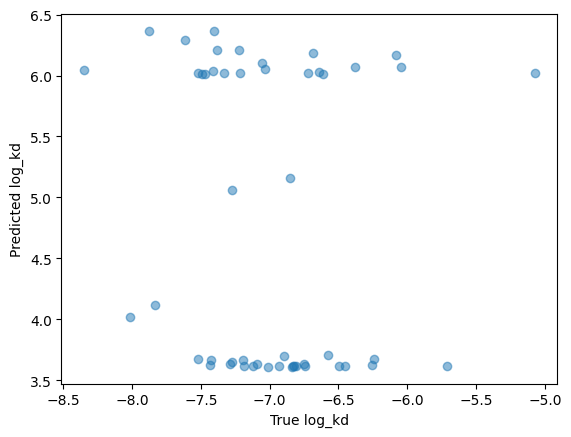

In [3]:
import matplotlib.pyplot as plt
df = pd.read_csv("/kaggle/working/test_predictions_AID1379.csv")
plt.scatter(df["targets"], df["predictions"], alpha=0.5)
plt.xlabel("True log_kd")
plt.ylabel("Predicted log_kd")
plt.savefig("/kaggle/working/scatter_AID1379.png")